In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from numpy import where
from numpy import nanmax
from numpy import nanmean
from numpy import nan
import itertools
import random
from pathlib import Path

class Solutions:

    def __init__(self,solver, selected_set, size,ids, times, counts, errors):
        self.solver = solver
        self.set=selected_set
        self.size = size
        self.ids = ids
        self.times = times
        self.counts = counts
        self.errors = errors

    def select(self, id):
        i = where(self.ids == str(id) )[0][0]
        print(i)
        print(self.ids)
        return {"id": self.ids[i], "time": self.times[i], "count": self.counts[i], "error": self.errors[i]}

    def get_error(self, id):
        return self.select(id)["error"]

    def get_count(self, id):
        return self.select(id)["count"]
    
    def get_time(self, id):
        return self.select(id)["time"]

    def get_time_max(self):
        return max(self.times)

    def get_count_max(self):
        return max(self.counts)

    def get_error_max(self):
        return nanmax(self.errors)

    def get_time_mean(self):
        return mean(self.times)

    def get_count_mean(self):
        return mean(self.counts)

    def get_error_mean(self):
        return nanmean(self.errors)

def getProgressof(solver_name, set, size,vc, problem_id):
    filename=f'PROGRESS/{solver_name}/wuf-{set}/wuf{vc}-{size}-{set}/w{problem_id}.mwcnf/problem0.dat'
    progress = pd.read_csv(filename, sep=' ', header=None).values
    return progress[:,0]

def getData(solver_names, sets, nums, pl, variables_count):
    solutions = []

    for (solver_name, set, num) in itertools.product(solver_names, sets, nums):

        vc = variables_count[nums.index(num)]
        ids = []
        times = []
        counts = []
        values = []

        for problem_id in pl:
            filename=f'OUT/{solver_name}/wuf-{set}/wuf{vc}-{num}-{set}/wuf{vc}-0{problem_id}.mwcnf'
            data=[]
            try:
                data = pd.read_csv(filename, sep=' ', header=None).values
            except:
                #print("file: " + filename + " not found")
                pass
            else:
                values.extend(data[:,0])
                times.extend(data[:,-1])
                counts.extend(data[:,-2])
                ids.append(f'uf{vc}-0{problem_id}')

        
        
        filename_ref = f'wuf-{set}/wuf{vc}-{num}-{set}-opt.dat'

        data_ref = pd.read_csv(filename_ref, sep=' ', header=None, on_bad_lines='skip').values
        
        ids_ref = data_ref[:,0]
        values_ref = data_ref[:,1]

        errors = []

        for id,index in zip(ids,range(len(ids))):
            try:
                i = where(ids_ref == id)[0][0]
            
            except:
                errors.append(nan)
                #print(id)
                
            else:
                if(values_ref[i] == 0):
                    errors.append(0)
                else:
                    errors.append( (values_ref[i] - values[index])/values_ref[i] )

        solutions.append(Solutions(solver_name, set, num,ids,times,counts,errors))

    return solutions

def listPlot(ax, data, solvers, set, sizes, colors, param):
    filtered_data = tuple(filter(lambda x: x.set == set, data))
    
    for (solver,color) in zip(solvers,colors):
        solver_data = tuple(filter(lambda x: x.solver == solver, filtered_data))

        if param == 'time':
            ax.plot( sizes, tuple(map(lambda x: x.get_time_max(),solver_data)),linestyle=':', label="max "+solver, c=color)
            ax.plot( sizes, tuple(map(lambda x: x.get_time_mean(),solver_data)), label="mean "+solver,c=color)

        if param == 'count':
            ax.plot( sizes, tuple(map(lambda x: x.get_count_max(),solver_data)),linestyle=':', label="max "+solver, c=color)
            ax.plot( sizes, tuple(map(lambda x: x.get_count_mean(),solver_data)), label="mean "+solver,c=color) 

        if param == 'error':
            ax.plot( sizes, tuple(map(lambda x: x.get_error_max(),solver_data)),linestyle=':', label="max "+solver, c=color)
            ax.plot( sizes, tuple(map(lambda x: x.get_error_mean(),solver_data)), label="mean "+solver,c=color)

    if param == 'time':
        ax.set(ylabel='time (s)',title='mean, max times ('+set+')')
    if param == 'count':
        ax.set(ylabel='count',title='mean, max counts ('+set+')')
    if param == 'error':
        ax.set(ylabel='relative error',title='mean, max errors ('+set+')')

    ax.legend()

def listPlot_n(ax, data, solver, sets, sizes, colors, param):
    solver_data = tuple(filter(lambda x: x.solver == solver, data))
    
    
    for (set,color) in zip(sets,colors):
        filtered_data = tuple(filter(lambda x: x.set == set, solver_data))

        if param == 'time':
            ax.plot( sizes, tuple(map(lambda x: x.get_time_max(),filtered_data)),linestyle=':', label="max "+set, c=color)
            ax.plot( sizes, tuple(map(lambda x: x.get_time_mean(),filtered_data)), label="mean "+set,c=color)

        if param == 'count':
            ax.plot( sizes, tuple(map(lambda x: x.get_count_max(),filtered_data)),linestyle=':', label="max "+set, c=color)
            ax.plot( sizes, tuple(map(lambda x: x.get_count_mean(),filtered_data)), label="mean "+set,c=color) 

        if param == 'error':
            ax.plot( sizes, tuple(map(lambda x: x.get_error_max(),filtered_data)),linestyle=':', label="max "+set, c=color)
            ax.plot( sizes, tuple(map(lambda x: x.get_error_mean(),filtered_data)), label="mean "+set,c=color)

    if param == 'time':
        ax.set(ylabel='time (s)',title='mean, max times ('+solver+')')
    if param == 'count':
        ax.set(ylabel='count',title='mean, max counts ('+solver+')')
    if param == 'error':
        ax.set(ylabel='relative error',title='mean, max errors ('+solver+')')

    ax.legend()

def histogram(ax, data, solvers, set, size, colors, param, bins):
    filtered_data = tuple(filter(lambda x: x.set == set and x.size == size, data))

    to_plot = []
    labels =[]
    for solver in solvers:
        solver_data = tuple(filter(lambda x: x.solver == solver, filtered_data))

        if param == 'time':
            to_plot.append(tuple(map(lambda x: x.times,solver_data))[0])
            labels.append(solver)

        if param == 'count':
            to_plot.append(tuple(map(lambda x: x.counts,solver_data))[0])
            labels.append(solver)

        if param == 'error':
            to_plot.append(tuple(map(lambda x: x.errors,solver_data))[0])
            labels.append(solver)

    ax.hist(to_plot, bins, color=colors, alpha=0.5, label=labels)

    if param == 'time':
        ax.set(xlabel='time (s)',title='time ('+set+str(size)+')')

    if param == 'count':
        ax.set(xlabel='count',title='counts ('+set+str(size)+')')

    if param == 'error':
        ax.set(xlabel='relative error',title='errors ('+set+str(size)+')')

    ax.legend()

def histogram_n(ax, data, solver, sets, size, colors, param, bins):
    solver_data = tuple(filter(lambda x: x.solver == solver and x.size == size, data))

    to_plot = []
    labels =[]
    for set in sets:
        filtered_data = tuple(filter(lambda x: x.set == set, solver_data))

        if param == 'time':
            to_plot.append(tuple(map(lambda x: x.times,filtered_data))[0])
            labels.append(set)

        if param == 'count':
            to_plot.append(tuple(map(lambda x: x.counts,filtered_data))[0])
            labels.append(set)

        if param == 'error':
            to_plot.append(tuple(map(lambda x: x.errors,filtered_data))[0])
            labels.append(set)

    ax.hist(to_plot, bins, color=colors, alpha=0.5, label=labels)

    if param == 'time':
        ax.set(xlabel='time (s)',title='time ('+solver+str(size)+')')

    if param == 'count':
        ax.set(xlabel='count',title='counts ('+solver+str(size)+')')

    if param == 'error':
        ax.set(xlabel='relative error',title='errors ('+solver+str(size)+')')

    ax.legend()

def progressPlot(ax, solver, set, size,vc, problemId, color):
    ax.plot(getProgressof(solver, set, size,vc, problemId), c=color, marker='.', markersize = 0.3, linestyle='')
    ax.set(ylabel='value',xlabel='iteration',title=set + ' ' + str(size) + ' problem: ' + str(problemId))
    #ax.legend()

In [35]:
solvers = ["SA"]

sets = ['A']
sizes = [88,91]
variables = [20, 20]

"""sets = ['M1', 'N1', 'Q1', 'R1']
sizes = [78,201]
variables = [20,50]"""

"""sets = ['M1']
sizes = [78,201]
variables = [20,50]"""

"""sets = ['N1']
sizes = [78,201]
variables = [20,50]"""

"""sets = ['Q1']
sizes = [78,201]
variables = [20,50]"""

"""sets = ['R1']
sizes = [201]
variables = [20,50]"""

pool=range(76)
printProgress = "false"

temperature = 50
cooling = 0.99
inner = 6
frozenDiff = 0.01
frozenSize = 0.1

In [36]:
data = getData( solvers, sets, sizes, pool, variables )

In [5]:
"""solver_index = random.randint(0,len(solvers)-1)
size_index = random.randint(0,len(sizes)-1)
set_index = random.randint(0,len(sets)-1)

solver = solvers[solver_index]
size = sizes[size_index]
set = sets[set_index]
vc = variables[size_index]

#size = 201
#vc = 50
#set = 'M1'

solutions = tuple(filter(lambda x: x.solver == solver and x.size == size and x.set == set, data))[0]

problem_index = random.randint(0,len(solutions.ids)-1)
problem_id = solutions.ids[problem_index]

#problem_id = 'uf50-024'
#problem_index = 0

print(f'{set} {size} {vc} {problem_id} [{problem_index}]')
print("total mean error: " + str(solutions.get_error_mean()))
print("total max error: " + str(solutions.get_error_max()))

print("error: " +  str(solutions.errors[problem_index]) )
print("last score: " + str(getProgressof(solver,set, size,vc, problem_id)[-1]) )
#print(solutions.select(problem_id))

fig, ax = plt.subplots(1,1)
fig.set_figwidth(14)

progressPlot(ax, solver, set, size,vc, problem_id, 'red')


plt.savefig('OUT/whitebox.png', bbox_inches='tight', dpi=400)

plt.show()"""

IndexError: tuple index out of range

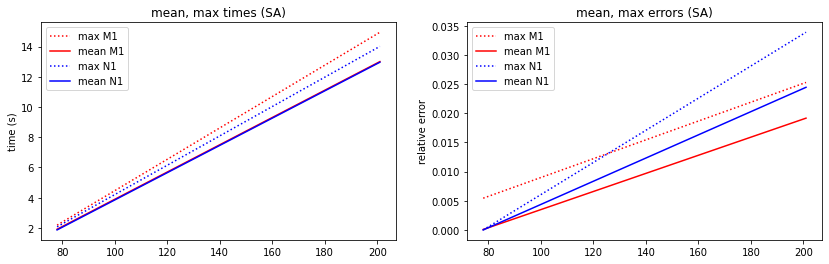

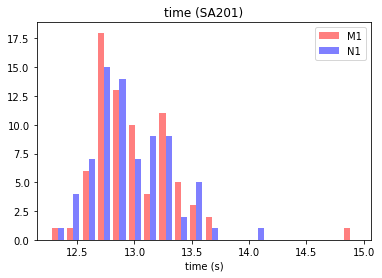

In [33]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)

listPlot_n(ax[0],data,'SA',['M1','N1'],sizes, ['red','blue'],'time')
listPlot_n(ax[1],data,'SA',['M1','N1'],sizes, ['red','blue'],'error')

plt.savefig('OUT/M1-N1-time-error.pdf', bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(1,1)

histogram_n(ax,data,'SA',['M1','N1'],sizes[-1], ['red','blue'],'time', 20)

plt.savefig('OUT/M1-N1-time-hist.pdf', bbox_inches='tight')

plt.show()

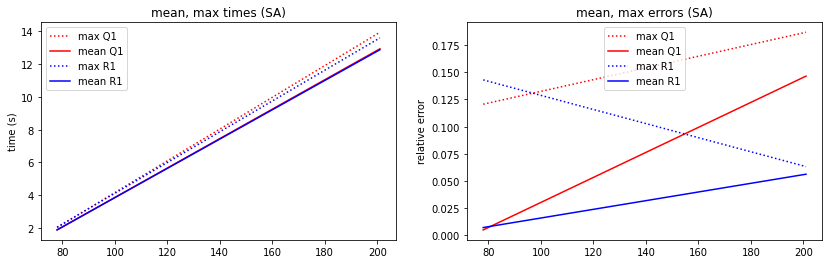

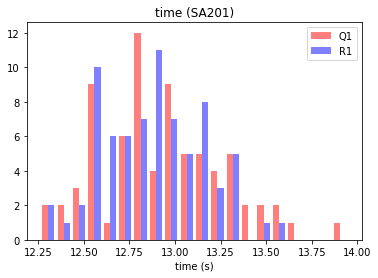

In [34]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)

listPlot_n(ax[0],data,'SA',['Q1','R1'],sizes, ['red','blue'],'time')
listPlot_n(ax[1],data,'SA',['Q1','R1'],sizes, ['red','blue'],'error')

plt.savefig('OUT/Q1-R1-time-error.pdf', bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(1,1)

histogram_n(ax,data,'SA',['Q1','R1'],sizes[-1], ['red','blue'],'time', 20)

plt.savefig('OUT/Q1-R1-time-hist.pdf', bbox_inches='tight')

plt.show()

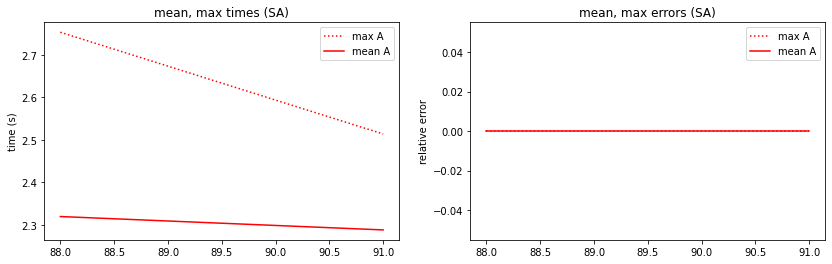

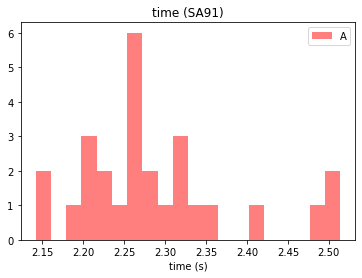

In [40]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)

listPlot_n(ax[0],data,'SA',['A'],sizes, ['red'],'time')
listPlot_n(ax[1],data,'SA',['A'],sizes, ['red'],'error')

plt.savefig('OUT/A-time-error.pdf', bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(1,1)

histogram_n(ax,data,'SA',['A'],sizes[-1], ['red'],'time', 20)

plt.savefig('OUT/A-time-hist.pdf', bbox_inches='tight')

plt.show()

In [ ]:
"""import os

for (size, selected_set, solver, problem_id) in itertools.product(sizes, sets, solvers, pool):
    vc = variables[sizes.index(size)]
    path = Path(f'wuf-{selected_set}/wuf{vc}-{size}-{selected_set}/wuf{vc}-0{problem_id}-{selected_set}.mwcnf')
    if path.is_file():
        n_path = Path(f'wuf-{selected_set}/wuf{vc}-{size}-{selected_set}/wuf{vc}-0{problem_id}.mwcnf')
        os.rename(path, n_path)"""

"import os\n\nfor (size, selected_set, solver, problem_id) in itertools.product(sizes, sets, solvers, pool):\n    vc = variables[sizes.index(size)]\n    path = Path(f'wuf-{selected_set}/wuf{vc}-{size}-{selected_set}/wuf{vc}-0{problem_id}-{selected_set}.mwcnf')\n    if path.is_file():\n        n_path = Path(f'wuf-{selected_set}/wuf{vc}-{size}-{selected_set}/wuf{vc}-0{problem_id}.mwcnf')\n        os.rename(path, n_path)"